In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import lifelines

# Loading the data

We wrapped the code that loads the data into its own Python script, called `main`. We will invoke it here.

In [2]:
import main
full_train = main.load_data(train=True)

2023-03-26 00:51:18,873	ERROR services.py:1365 -- Failed to start the dashboard: Failed to start the dashboard, return code 0
 The last 10 lines of /tmp/ray/session_2023-03-26_00-51-15_798672_2072422/logs/dashboard.log:
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/head.py", line 105, in _configure_http_server
    http_server = HttpServerDashboardHead(
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 68, in __init__
    raise ex
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 59, in __init__
    build_dir = setup_static_dir()
  File "/home/sam/micromamba/envs/datathon/lib/python3.10/site-packages/ray/dashboard/http_server_head.py", line 30, in setup_static_dir
    raise dashboard_utils.FrontendNotFoundError(
ray.dashboard.utils.FrontendNotFoundError: [Errno 2] Dashboard build directory not found. If installing from sour

The data is quite large, and we can more quickly squeeze out all of the insights from a random sample of the data. **If your machine is powerful enough**, comment this line out.

In [3]:
train = full_train.sample(frac=0.1, random_state=0)
#train = full_train

Note that not all of these columns actually exist in the forecast data (their value is unknown). Therefore, we create `useful_columns`. But we need to keep `charge_off` for scoring.

In [4]:
useful_columns = list((set(train.columns) - set(main.hidden_cols)) | {"charge_off"})
useful_columns.sort()

# Data cleaning

FICO scores are stored as buckets (categorical). Rather than find a coefficient for each bucket independently, we will replace this with a numerical value, and find one coefficient to multiply it by. We want to map each bucket to its midpoint.

In [5]:
train["bank_fico_buckets_20"].value_counts()

761+         208363
701-720       55559
681-700       54892
721-740       51786
661-680       50715
741-760       45531
641-660       41533
621-640       26658
601-620       15198
581-600        8433
<= 560         7820
561-580        5385
Missing        3169
Exception       780
Name: bank_fico_buckets_20, dtype: int64

In [6]:
def convert_fico(fico_bucket):
    fico_bucket=str(fico_bucket)
    if fico_bucket == '761+':
        return (761+850)/2
    elif fico_bucket == '<= 560':
        return (560+300)/2
    elif fico_bucket == 'Exception' or fico_bucket == 'Missing':
        return np.NaN
    else:
        lower, upper = fico_bucket.split('-')
        return (float(lower)+float(upper))/2

def add_fico_score(df):
    df['fico_score'] = df['bank_fico_buckets_20'].apply(convert_fico)
    return df

train = add_fico_score(train)

Unfortunately, there are some missing data in the fico scores.

In [7]:
pd.isna(train["fico_score"]).value_counts()

False    571873
True       3949
Name: fico_score, dtype: int64

In [8]:
train['fico_score'].fillna(train['fico_score'].mean(), inplace=True)

Now we drop columns that are more than 50% NaNs.

In [9]:
nan_features = []
threshold = 0.5
for feature in useful_columns:
    if train[feature].isna().sum() / len(train) > threshold:
        nan_features.append(feature)
train.drop(nan_features, axis=1, inplace=True)
nan_features

['charge_off_reason_code', 'variable_rate_margin', 'writeoff_date']

# Feature selection

Now we compute the correlation matrix to identify features to use in our model. Note that we take an absolute value because we don't care if the feature is positively or negatively correlated.

In [10]:
train_corr = train.corr(numeric_only=True)
abs(train_corr['charge_off']).sort_values(ascending=False).head(20)

charge_off                  1.000000
active                      1.000000
writeoff_type_null          0.996029
charge_off_aged             0.930430
writeoff_type_aged          0.898249
fee_reversals               0.775233
total_writeoff_amt          0.704676
fee_chg_off_reversal_amt    0.686285
aged_writeoff_amt           0.652829
principal_amt_chrg_off      0.561495
fc_reversals                0.544853
writeoff_type_bko           0.346199
charge_off_bk               0.343333
bankruptcy_writeoff_amt     0.219029
writeoff_type_deceased      0.213144
nbr_mths_due                0.212326
writeoff_type_settlement    0.188555
other_writeoff_amt          0.188215
recovery_amt                0.124599
fico_score                  0.101082
Name: charge_off, dtype: float64

We found out the hard way that `total_writeoff_amt` and `principal_amt_chrg_off` is too correlated with the target and will cause divergence problem in the CPH fitting process, so we exclude these two features

In [11]:
features = [
    'nbr_mths_due',
    'fico_score',
    'credit_limit_amt',
    'prev_balance',
    'financial_active',
    'purchase_active',
    'promotion_flag',
    'active_12_mths'
]

Now we select these features and standardize.

In [12]:
temp = train[features]
# Save these for later!
temp_mean = temp.mean()
temp_std = temp.std()
X = (temp - temp_mean) / temp_std
X['time_elapsed'] = train['time_elapsed']
X['charge_off'] = train['charge_off']

# Survival analysis

To use these numerical features, we find that CPH only converge with a penalizer, but when there is a penalizer, the coefficients are all close to 1, which is hard to intepret.

In [13]:
from lifelines import CoxPHFitter
cph = CoxPHFitter(penalizer=1)
cph.fit(X, duration_col='time_elapsed', event_col='charge_off')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574307 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
                penalizer = 1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1515
   partial log-likelihood = -18650.05
         time fit was run = 2023-03-26 05:52:30 UTC

---
                   coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                
nbr_mths_due       0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
fico_score        -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
credit_limit_amt  -0.00       1.00       0.00            -0.01            -0.00                 0.99                 1.00
prev_balance       0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
financial_active   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
purchase_active   -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
promotion_flag     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
active_12_mths     0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00

                   cmp to     z      p   -log2(p)
covariate                                        
nbr_mths_due         0.00  8.25 <0.005      52.54
fico_score           0.00 -3.92 <0.005      13.44
credit_limit_amt     0.00 -2.19   0.03       5.13
prev_balance         0.00  1.77   0.08       3.71
financial_active     0.00  1.40   0.16       2.64
purchase_active      0.00 -0.95   0.34       1.55
promotion_flag       0.00  0.78   0.43       1.21
active_12_mths       0.00  0.71   0.48       1.06
---
Concordance = 0.96
Partial AIC = 37316.10
log-likelihood ratio test = 95.39 on 8 df
-log2(p) of ll-ratio test = 54.58

This plot shows us CI of the coefficients of the various factors on the hazard function. If the coefficient is positive, then the factor increases the probability of chargeoff. If the coefficient straddles zero, the feature is likely not relevant.

<AxesSubplot: xlabel='log(HR) (95% CI)'>

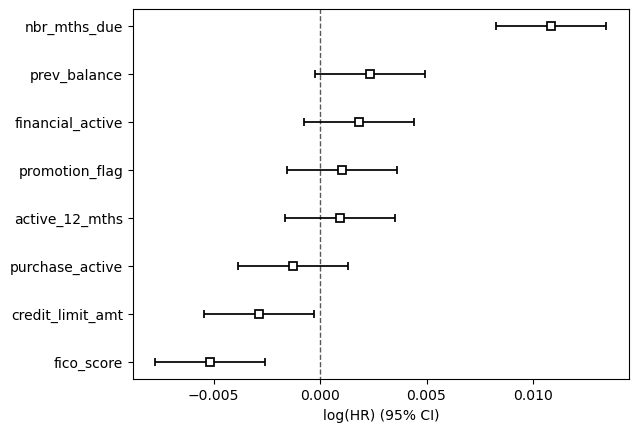

In [14]:
cph.plot()

Most of the coefficients are close to zero, which means they have a very small impact on the result. We can also see this from the partial effects graph:

<AxesSubplot: >

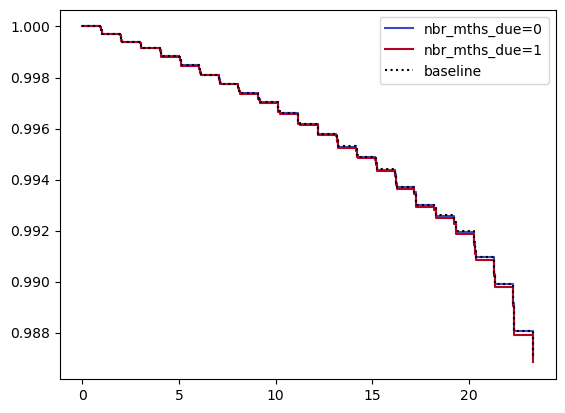

In [15]:
cph.plot_partial_effects_on_outcome(covariates='nbr_mths_due', values=[0, 1], cmap='coolwarm')

# Survival analysis with quantized features

Outliers and non-linear effects can greatly influence the survival analysis, so we exclude those by thresholding the data. Instead of entering the data directly, we just enter if it is greater than the threshold.

In [16]:
def add_quantized_features(df):
    #Also adding a column with low/high (0/1) credit score (using 661 and up as high based off a quick google search)
    df['fico_low_high'] = df['fico_score'].map(lambda x: 1.0 if x <= 660 else 0.0)

    #Create column with high/low credit limit amounts (>5000) high
    df['credit_limit_high_low'] = df['credit_limit_amt'].map(lambda x: 1.0 if x < 5000 else 0.0)

    #Creating a column with difference between current balance and previous balance
    df['balance_diff'] = df['stmt_balance'] - df['prev_balance']

    #Creating a column with low/high increase in balance from previous statement (high >5000)
    df['new_balance_diff_high_low'] = df['balance_diff'].map(lambda x: 1.0 if x < 5000 else 0.0)

    #Creating column with low/high number of monthly payments due (high >=5)
    df['mths_due_high_low'] = df['nbr_mths_due'].map(lambda x: 1.0 if x >= 5 else 0.0)
    
    return df

train = add_quantized_features(train)    

train

,financial_active,net_payment_behaviour_tripd,promotion_flag,variable_rate_index,account_status_code,active_12_mths,bank_fico_buckets_20,mob,open_closed_flag,ever_delinquent_flg,...,snapshot,mth_code,industry,time_elapsed,fico_score,fico_low_high,credit_limit_high_low,balance_diff,new_balance_diff_high_low,mths_due_high_low
3613772,True,I,False,False,I 7-12,True,621-640,57,1.0,True,...,2018-10-01,2018-10-01,B,0.000000,630.5,1.0,1.0,1310.99,1.0,0.0
3887009,False,I,True,False,A,True,681-700,145,1.0,False,...,2018-11-01,2018-11-01,B,0.000000,690.5,0.0,1.0,0.00,1.0,0.0
2721972,False,P,True,False,I 13-24,True,761+,15,1.0,False,...,2018-07-01,2019-12-01,B,17.266667,805.5,0.0,0.0,-556.15,1.0,0.0
77795,True,I,False,False,A,True,721-740,17,1.0,False,...,2018-01-01,2018-09-01,B,8.100000,730.5,0.0,0.0,-2456.99,1.0,0.0
5133318,False,P,False,False,A,True,701-720,10,1.0,False,...,2019-05-01,2019-10-01,C,5.100000,710.5,0.0,0.0,0.00,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879148,False,R,False,False,I 0-6,True,761+,71,1.0,False,...,2018-08-01,2019-12-01,B,16.233333,805.5,0.0,0.0,0.00,1.0,0.0
1956114,True,T,True,False,A,True,741-760,114,1.0,False,...,2018-05-01,2018-10-01,B,5.100000,750.5,0.0,0.0,0.00,1.0,0.0
2864221,False,D,False,False,I 0-6,True,761+,35,1.0,False,...,2018-08-01,2019-09-01,B,13.200000,805.5,0.0,1.0,-395.91,1.0,0.0
4167701,False,I,False,False,I 0-6,True,661-680,45,1.0,False,...,2018-12-01,2019-08-01,B,8.100000,670.5,0.0,0.0,-559.55,1.0,0.0


In [17]:
quantized_features = ['financial_active', 'fico_low_high', 'ever_delinquent_flg', 'credit_limit_high_low', 'new_balance_diff_high_low']
cph = CoxPHFitter(penalizer=0)
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574307 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1515
   partial log-likelihood = -16412.12
         time fit was run = 2023-03-26 05:52:38 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.96      19.30       0.15             2.66             3.26                14.34                25.96
fico_low_high               2.66      14.24       0.06             2.54             2.77                12.65                16.02
ever_delinquent_flg         0.40       1.49       0.07             0.26             0.54                 1.30                 1.71
credit_limit_high_low       2.83      16.88       0.14             2.55             3.10                12.86                22.14
new_balance_diff_high_low   1.47       4.33       0.35             0.77             2.16                 2.16                 8.68

                            cmp to     z      p   -log2(p)
covariate                                                 
financial_active              0.00 19.56 <0.005     280.56
fico_low_high                 0.00 44.08 <0.005        inf
ever_delinquent_flg           0.00  5.71 <0.005      26.41
credit_limit_high_low         0.00 20.39 <0.005     304.65
new_balance_diff_high_low     0.00  4.14 <0.005      14.78
---
Concordance = 0.90
Partial AIC = 32834.25
log-likelihood ratio test = 4571.24 on 5 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

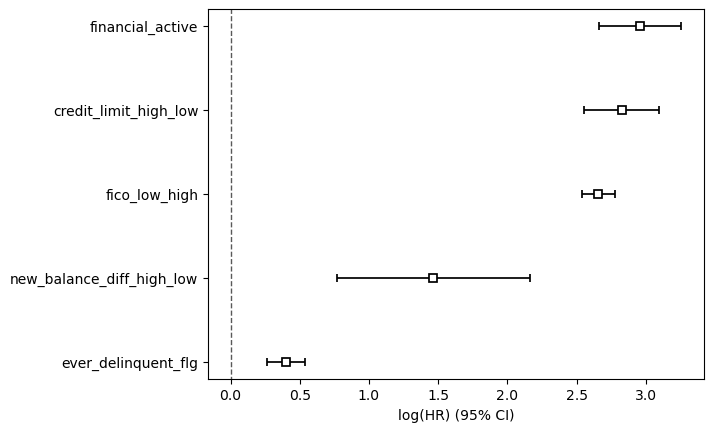

In [18]:
cph.plot()

This model does much better. Let's look at the partial_effects plot.

<AxesSubplot: >

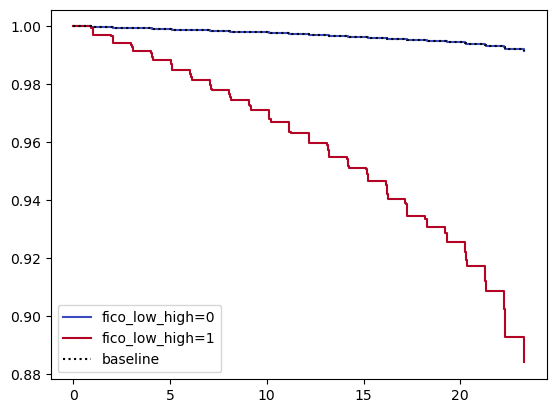

In [19]:
cph.plot_partial_effects_on_outcome(covariates='fico_low_high', values=[0, 1], cmap='coolwarm')

# Survival analysis with quantized and categorical features

We know that several categorical variables impact the chargeoff outcome. To encode these variables, we use a one-hot encoding.

In [20]:
cat_vars = ['net_payment_behaviour_tripd', 'account_status_code', 'industry']
def one_hot_encode(df):
    return pd.get_dummies(df, columns=cat_vars, drop_first=True)
train = one_hot_encode(train)

In [21]:
net_payment_behaviour_tripd_features = []
account_status_code_features = []
industry_features = []

for column in train.columns:
    if column.startswith('net_payment_behaviour_tripd'):
        net_payment_behaviour_tripd_features.append(column)
    elif column.startswith('account_status_code'):
        account_status_code_features.append(column)
    elif column.startswith('industry'):
        industry_features.append(column)
net_payment_behaviour_tripd_features, account_status_code_features, industry_features

(['net_payment_behaviour_tripd_D',
  'net_payment_behaviour_tripd_I',
  'net_payment_behaviour_tripd_P',
  'net_payment_behaviour_tripd_R',
  'net_payment_behaviour_tripd_T'],
 ['account_status_code_I 0-6',
  'account_status_code_I 13-24',
  'account_status_code_I 25+',
  'account_status_code_I 7-12',
  'account_status_code_MonthEnd',
  'account_status_code_Recovery',
  'account_status_code_W',
  'account_status_code_Clchange'],
 ['industry_B', 'industry_C'])

In [22]:
cph = CoxPHFitter(penalizer=0)
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features, *industry_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574307 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1515
   partial log-likelihood = -16354.46
         time fit was run = 2023-03-26 05:52:43 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.96      19.21       0.15             2.66             3.25                14.28                25.84
fico_low_high               2.65      14.20       0.06             2.53             2.77                12.62                15.98
ever_delinquent_flg         0.41       1.50       0.07             0.27             0.55                 1.31                 1.73
credit_limit_high_low       2.82      16.82       0.14             2.55             3.09                12.82                22.06
new_balance_diff_high_low   1.46       4.32       0.35             0.77             2.16                 2.16                 8.66
industry_B                 -0.61       0.54       0.06            -0.72            -0.50                 0.49                 0.61
industry_C                 -0.55       0.58       0.08            -0.70            -0.40                 0.50                 0.67

                            cmp to      z      p   -log2(p)
covariate                                                  
financial_active              0.00  19.53 <0.005     279.68
fico_low_high                 0.00  44.04 <0.005        inf
ever_delinquent_flg           0.00   5.81 <0.005      27.23
credit_limit_high_low         0.00  20.37 <0.005     303.89
new_balance_diff_high_low     0.00   4.13 <0.005      14.74
industry_B                    0.00 -10.76 <0.005      87.23
industry_C                    0.00  -7.07 <0.005      39.19
---
Concordance = 0.91
Partial AIC = 32722.93
log-likelihood ratio test = 4686.56 on 7 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

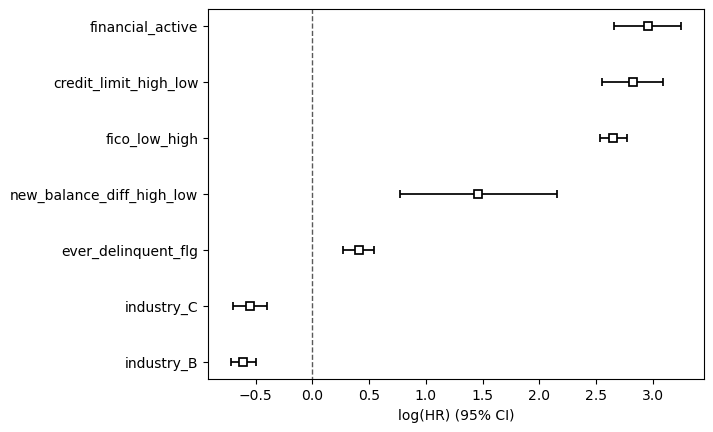

In [23]:
cph.plot()

Now we are incorporating a categorical feature!

<AxesSubplot: >

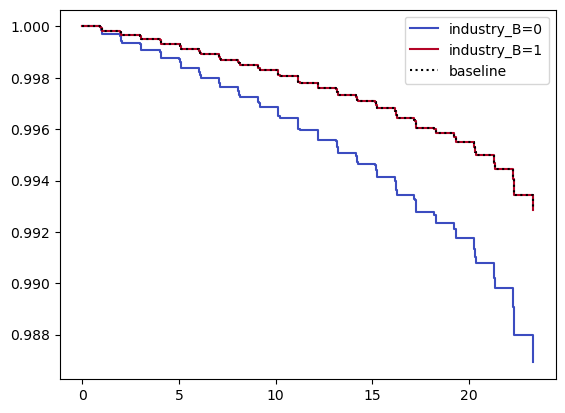

In [24]:
cph.plot_partial_effects_on_outcome(covariates='industry_B', values=[0, 1], cmap='coolwarm')

# Macro data

In [25]:
macro_data = pd.read_csv('data/macro_data.csv')
macro_data.head(10)

,Mnemonic,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,M_FYFMMEDQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,Description,Baseline Scenario (October 2022): FHFA Purchas...,Baseline Scenario (October 2022): NIPA: Income...,Baseline Scenario (October 2022): Retail Sales...,Baseline Scenario (October 2022): Income: Pers...,Baseline Scenario (October 2022): NIPA: Person...,Baseline Scenario (October 2022): Income: Per ...,Baseline Scenario (October 2022): NIPA: Gross ...,Baseline Scenario (October 2022): Average Hous...,Baseline Scenario (October 2022): Median Famil...,...,Baseline Scenario (June 2020): Charge Off Rate...,Baseline Scenario (June 2020): Employment: Tot...,Baseline Scenario (June 2020): Terms Conventio...,Baseline Scenario (June 2020): NIPA: Personal ...,Baseline Scenario (June 2020): U.S. All Grades...,Baseline Scenario (June 2020): Motor gasoline ...,Baseline Scenario (June 2020): Merrill Lynch 1...,Baseline Scenario (June 2020): Homeownership R...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...,FRB CCAR 2020 - Severely Adverse: NIPA: Fixed ...
1,Name,"FHFA Purchase-Only Home Price Index, (Index 19...","NIPA: Income - Compensation of Employees, (Bil...","Retail Sales - Retail Sales Total, (Bil. USD, ...","Income: Personal - Saving Rate, (%, SA)",NIPA: Personal Consumption Expenditures - Tota...,"Income: Per Capita Income, (USD)","NIPA: Gross Domestic Product, (Bil. USD, SAAR)","Average Household Income: All Races, (USD, SA)","Median Family Income: All Races, (USD, SA)",...,Charge Off Rates: All Commercial Banks - Credi...,"Employment: Total Private, (Mil. #, SA)",Terms Conventional Mortgages: All Loans - Comp...,NIPA: Personal Consumption Expenditures - Tota...,U.S. All Grades All Formulations Retail Gasoli...,"Motor gasoline prices: Unleaded, (Cents per ga...","Merrill Lynch 10-Year Bbb Corporate Bond Rate,...","Homeownership Rate, (%, SA)","NIPA: Fixed Investment - Residential - Total, ...","NIPA: Fixed Investment - Residential - Total, ..."
2,Source,U.S. Federal Housing Finance Agency (FHFA); Fr...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Census Bureau (BOC); U.S. Bureau of Econo...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,...,U.S. Board of Governors of the Federal Reserve...,U.S. Bureau of Labor Statistics (BLS); Moody's...,U.S. Federal Housing Finance Board (FHFB); Moo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Energy Information Administration (EIA); ...,Oil Price Information Service (OPIS); Moody's ...,U.S. Board of Governors of the Federal Reserve...,U.S. Census Bureau (BOC); Moody's Analytics Fo...,U.S. Bureau of Economic Analysis (BEA); Moody'...,U.S. Bureau of Economic Analysis (BEA); Moody'...
3,Native Frequency,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,ANNUAL,MONTHLY,MONTHLY,MONTHLY,...,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY,MONTHLY
4,Geography,United States,United States,United States,United States,United States,United States,United States,United States,United States,...,United States,United States,United States,United States,United States,United States,United States,United States,United States,United States
5,Last Updated,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/11/2022,10/10/2022,10/11/2022,10/11/2022,10/11/2022,...,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,6/9/2020,2/8/2020,2/8/2020
6,Historical End Date,7/31/2022,8/31/2022,8/31/2022,8/31/2022,8/31/2022,12/31/2020,6/30/2022,6/30/2020,3/31/2022,...,12/31/2019,5/31/2020,4/30/2019,4/30/2020,5/31/2020,5/31/2020,9/30/2018,3/31

In [26]:
# data starts from row 7
macro_data_clean = macro_data.iloc[7:,:].copy()
# The first column, labelled "mnemonic", contains the date
# The macro data is collated for the last day of the month.
# We will reindex this as the first day of the next month, so we can match it against mth_code
macro_data_clean['mth_code'] = pd.DatetimeIndex(pd.to_datetime(macro_data_clean['Mnemonic'])) + pd.DateOffset(1)
# These get read as strings; need to convert to floats
real_cols = [col for col in macro_data_clean.columns if col.startswith("M_")]
for col in real_cols:
    macro_data_clean[col] = macro_data_clean[col].apply(lambda x: pd.to_numeric(x, errors="coerce"))

We want to correlate the macroeconomic trends with the monthly chargeoff rate, which we compute below:

In [27]:
train_mth_code = (
      train[['mth_code', 'charge_off']].groupby('mth_code').sum()
    / train[['mth_code', 'charge_off']].groupby('mth_code').count()
)
train_mth_code

,charge_off
mth_code,
2018-01-01,0.000000
2018-02-01,0.001265
2018-03-01,0.003746
2018-04-01,0.002549
2018-05-01,0.002110
2018-06-01,0.002593
2018-07-01,0.002683
2018-08-01,0.003584
2018-09-01,0.002805


In [28]:
train_macro_combined = train_mth_code.merge(macro_data_clean, on='mth_code').drop(['Mnemonic'], axis=1)
train_macro_combined

,mth_code,charge_off,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,...,M_FBCFCOFCCQ.IUSA,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA
0,2018-01-01,0.000000,247.111273,10714.677,5209.548,6.3,13609.029,52856.89199,20034.78511,137521.2505,...,3.672078,125.170,79.000000,12785.503,2.59375,248.2625,3.938416,64.075495,782.325839,621.133072
1,2018-02-01,0.001265,248.873161,10761.294,5181.420,7.1,13628.374,53049.86599,20073.62463,138178.1894,...,3.664279,125.317,79.500000,12775.504,2.67120,253.4600,4.058025,64.182997,782.999266,616.305314
2,2018-03-01,0.003746,250.867813,10780.022,5215.572,7.2,13668.318,53233.38442,20141.45839,138578.5727,...,3.650039,125.672,79.300000,12765.158,2.70475,256.9375,4.206673,64.299439,783.218171,611.378013
3,2018-04-01,0.002549,251.669258,10808.394,5198.868,7.2,13735.355,53417.1033,20251.37579,139015.1391,...,3.635683,125.850,79.200000,12808.044,2.70900,255.9775,4.374299,64.417509,784.849562,608.511673
4,2018-05-01,0.002110,252.396284,10850.006,5220.732,7.2,13792.129,53607.57795,20361.75240,139415.5111,...,3.627844,125.977,79.200000,12863.202,2.87320,272.1040,4.530713,64.508728,787.505316,607.257917
5,2018-06-01,0.002593,253.727295,10884.605,5277.108,7.2,13860.171,53798.93234,20482.75073,139951.8411,...,3.634638,126.238,78.900000,12918.212,2.98675,290.1200,4.625637,64.528112,789.935821,606.495716
6,2018-07-01,0.002683,254.826464,10938.375,5250.324,7.4,13900.213,53991.49272,20566.09014,140544.0184,...,3.657519,126.429,78.700000,12946.163,2.96950,292.2250,4.637647,64.462223,791.133864,605.149367
7,2018-08-01,0.003584,255.897096,11000.556,5285.064,7.5,13952.254,54185.6046,20646.54348,141261.2749,...,3.680373,126.562,79.000000,12992.581,2.92780,288.4640,4.612022,64.375857,790.916523,603.062019
8,2018-09-01,0.002805,257.158370,11056.842,5278.512,7.6,14001.103,54384.72451,20705.33069,141810.1233,...,3.681015,126.778,78.800000,13035.279,2.91425,287.6625,4.617717,64.360913,789.302998,600.235604
9,2018-10-01,0.003085,257.554349,11071.396,5272.152,7.7,14013.025,54582.57541,20709.96619,141969.5417,...,3.648614,126.859,78.000000,13031.547,2.91475,287.2450,4.696259,64.465337,786.732479,597.056377


# Feature selection for macroeconomic trends

In [29]:
# Compute mutual information of columns of financial index with charge_off frequency
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(
    train_macro_combined.drop(columns=["mth_code", "charge_off"]),
    train_macro_combined["charge_off"],
)
mi_scores[:3]  # show a few features with their MI scores

M_FHCLHP1TI20Q.IUSA    0.440980
M_FBKBY.IUSA           0.436792
M_FCUMF.IUSA           0.429340
Name: MI Scores, dtype: float64

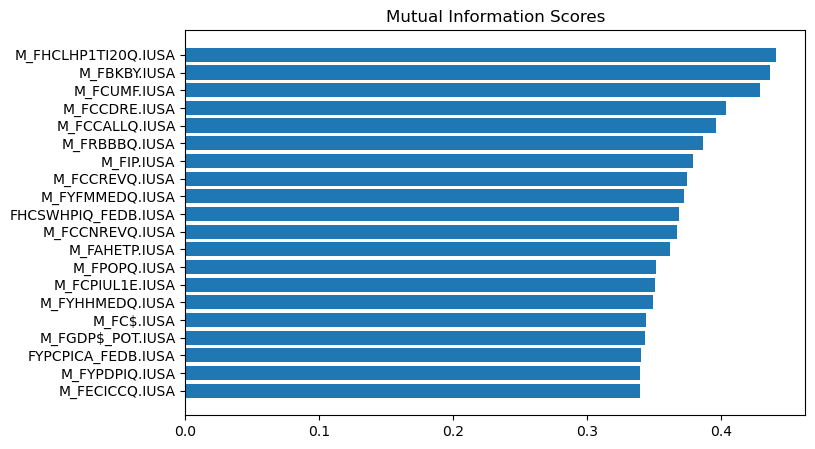

In [30]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[:20])

Thus we add the M_FRBAAC.IUSA and M_FRBBBQ.IUSA columns in the training data

In [31]:
macro_features = ['M_FRBAAC.IUSA', 'M_FRBBBQ.IUSA']
train = train.merge(train_macro_combined[['mth_code', *macro_features]], on='mth_code')

In [32]:
cph = CoxPHFitter()
cph.fit(
    train[['time_elapsed', 'charge_off', *quantized_features, *industry_features, *macro_features]],
    duration_col='time_elapsed',
    event_col='charge_off',
)
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 575822 total observations, 574307 right-censored observations>
             duration col = 'time_elapsed'
                event col = 'charge_off'
      baseline estimation = breslow
   number of observations = 575822
number of events observed = 1515
   partial log-likelihood = -16175.75
         time fit was run = 2023-03-26 05:52:52 UTC

---
                            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                         
financial_active            2.93      18.75       0.15             2.63             3.23                13.94                25.23
fico_low_high               2.65      14.20       0.06             2.54             2.77                12.62                15.98
ever_delinquent_flg         0.40       1.49       0.07             0.26             0.54                 1.30                 1.72
credit_limit_high_low       2.82      16.76       0.14             2.55             3.09                12.77                21.99
new_balance_diff_high_low   1.43       4.17       0.35             0.73             2.12                 2.08                 8.36
industry_B                 -0.60       0.55       0.06            -0.72            -0.49                 0.49                 0.61
industry_C                 -0.55       0.58       0.08            -0.70            -0.40                 0.50                 0.67
M_FRBAAC.IUSA               0.05       1.06       0.18            -0.30             0.41                 0.74                 1.51
M_FRBBBQ.IUSA               1.08       2.93       0.18             0.72             1.43                 2.06                 4.16

                            cmp to      z      p   -log2(p)
covariate                                                  
financial_active              0.00  19.37 <0.005     275.22
fico_low_high                 0.00  44.04 <0.005        inf
ever_delinquent_flg           0.00   5.72 <0.005      26.51
credit_limit_high_low         0.00  20.34 <0.005     303.14
new_balance_diff_high_low     0.00   4.03 <0.005      14.14
industry_B                    0.00 -10.66 <0.005      85.67
industry_C                    0.00  -7.10 <0.005      39.56
M_FRBAAC.IUSA                 0.00   0.30   0.77       0.38
M_FRBBBQ.IUSA                 0.00   6.01 <0.005      29.02
---
Concordance = 0.93
Partial AIC = 32369.50
log-likelihood ratio test = 5043.99 on 9 df
-log2(p) of ll-ratio test = inf

<AxesSubplot: xlabel='log(HR) (95% CI)'>

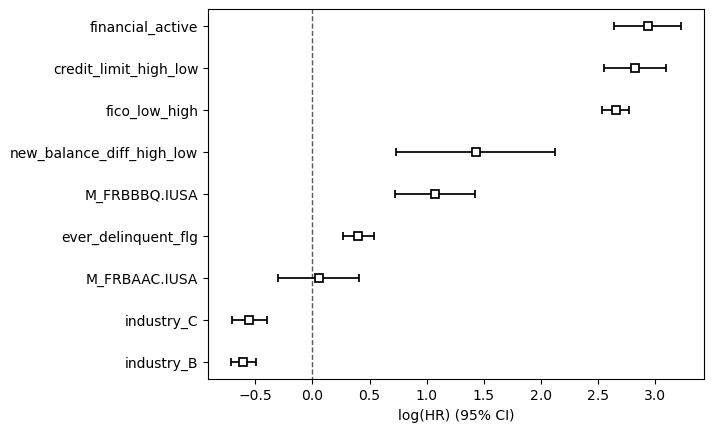

In [33]:
cph.plot()

Again, we will plot some partial effects curves to validate the significance.

<AxesSubplot: >

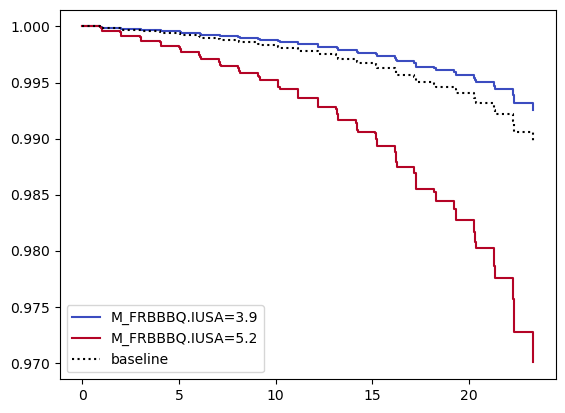

In [34]:
cph.plot_partial_effects_on_outcome(covariates='M_FRBBBQ.IUSA',values=[3.9, 5.2], cmap='coolwarm')

# The full prediction

We are asked to make predicitons for the `forecast_data.csv`.

In [35]:
forecast_data = main.load_data(train=False)
forecast_data

,financial_active,net_payment_behaviour_tripd,promotion_flag,variable_rate_index,account_status_code,active_12_mths,bank_fico_buckets_20,charge_off_reason_code,mob,open_closed_flag,...,due_balance_3,due_balance_4,due_balance_5,due_balance_6,due_balance_7,due_balance_8,snapshot,mth_code,industry,time_elapsed
0,True,T,False,False,I 0-6,True,761+,NaN,42,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0
1,False,P,False,False,A,True,761+,NaN,48,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0
2,False,C,False,False,I 0-6,False,761+,NaN,244,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
3,True,R,False,False,I 0-6,True,621-640,NaN,76,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
4,True,P,False,False,I 0-6,True,761+,NaN,143,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19861,True,I,True,False,I 13-24,True,621-640,NaN,26,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,A,0.0
19862,False,R,True,False,A,True,641-660,NaN,299,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
19863,True,I,False,False,I 0-6,True,741-760,NaN,4,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,C,0.0
19864,True,P,True,True,A,True,701-720,NaN,24,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2020-01-01,2020-01-01,B,0.0


Now we must do the exact same data transformations to `forecast_data`.

In [36]:
forecast_data = add_fico_score(forecast_data)
forecast_data = add_quantized_features(forecast_data)    
forecast_data = one_hot_encode(forecast_data)

Hopefully, it all starts from the same date.

In [37]:
start_dates = list(forecast_data["snapshot"].unique())
assert len(start_dates) == 1
start_date = start_dates[0]
start_date

numpy.datetime64('2020-01-01T00:00:00.000000000')

The macroeconomic trends a bit more complicated. We want to join with the macroenomic trends for the date **of prediction**.

In [38]:
dates_of_interest = [np.datetime64(f"2020-{i:02}-01") for i in range(2, 13)] + [np.datetime64("2021-01-01")]

Suppose we select a certain datetime

In [39]:
date = dates_of_interest[7]
macro_data_clean[macro_data_clean["mth_code"] == date]

,Mnemonic,M_FHOFHOPIPOQ.IUSA,M_FYLE.IUSA,M_FRT.IUSA,M_FYPSAVQ.IUSA,M_FC.IUSA,FYPCPICA_FEDB.IUSA,M_FGDP.IUSA,M_FYHHAVGQ.IUSA,M_FYFMMEDQ.IUSA,...,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA,mth_code
254,8/31/2020,291.514853,11573.878,5788.692,15.5,14352.773,60704.02875,21364.07023,156028.7664,83874.19365,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01


Now we want to copy this one row of macro data for every row of forecast data. This can be thought of as a cross-product, $N \times 1 = N$

In [40]:
macro_info = macro_data_clean[macro_data_clean["mth_code"] == date]
new_forecast_data = pd.merge(forecast_data, macro_info, how="cross")
new_forecast_data

,financial_active,promotion_flag,variable_rate_index,active_12_mths,bank_fico_buckets_20,charge_off_reason_code,mob,open_closed_flag,ever_delinquent_flg,nbr_mths_due,...,M_FETP.IUSA,M_FLTV.IUSA,M_FC$.IUSA,M_FEIAMGTTQ.IUSA,M_FXCPMGASUQ.IUSA,M_FRBBBQ.IUSA,M_FHOWNRQ.IUSA,M_FIFR_FEDS.IUSA,M_FIFR$_FEDS.IUSA,mth_code_y
0,True,False,False,True,761+,NaN,42,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
1,False,False,False,True,761+,NaN,48,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
2,False,False,False,False,761+,NaN,244,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
3,True,False,False,True,621-640,NaN,76,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
4,True,False,False,True,761+,NaN,143,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19861,True,True,False,True,621-640,NaN,26,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
19862,False,True,False,True,641-660,NaN,299,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
19863,True,False,False,True,741-760,NaN,4,1.0,True,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01
19864,True,True,True,True,701-720,NaN,24,1.0,False,0,...,120.936674,76.892728,12793.73645,2.09836,204.258521,2.994674,64.708792,853.564693,610.982942,2020-09-01


Now we would use CPH to predict how long these accounts will survive.

In [41]:
predictions = cph.predict_survival_function(
    X=new_forecast_data,
    times=[(date - start_date) / pd.Timedelta(days=30)],
).T
predictions

,8.133333
0,0.999641
1,0.999981
2,0.999998
3,0.990696
4,0.999977
...,...
19861,0.990696
19862,0.999983
19863,0.999433
19864,0.999641


If we have 100 individuals each with 99% chance of survival, we simply add them up to find the expected number of survivors.
$$\mathbb E(|N|) = \sum\limits_{x \in N} \mathbb E(x) = \sum\limits_{x \in N} \mathbb P(x)$$

In [42]:
predictions.sum()

8.133333    19855.576004
dtype: float64

In [43]:
predictions_by_date = []
for date in dates_of_interest:
    macro_info = macro_data_clean[macro_data_clean["mth_code"] == date]
    assert len(macro_info) == 1
    new_forecast_data = pd.merge(forecast_data, macro_info, how="cross")
    prediction = cph.predict_survival_function(
        X=new_forecast_data,
        times=[(date - start_date) / pd.Timedelta(days=30)],
    ).sum(axis=1).iloc[0]
    predictions_by_date.append(prediction)
    print(date, prediction)

2020-02-01 19863.52503199364
2020-03-01 19861.45113757177
2020-04-01 19855.424692269036
2020-05-01 19847.196279118412
2020-06-01 19837.95758894758
2020-07-01 19845.360751476645
2020-08-01 19852.454097921982
2020-09-01 19855.576004491693
2020-10-01 19853.531552224602
2020-11-01 19844.17608801714
2020-12-01 19831.37663362806
2021-01-01 19825.738869755147


In [51]:
output = pd.DataFrame.from_records(zip(dates_of_interest, predictions_by_date), columns=["Month", "accounts_charged_off"])
output["Month"] = output["Month"].apply(lambda x: x.strftime("%Y%M"))
output["accounts_charged_off"] = output["accounts_charged_off"].astype(int)
output

,Month,accounts_charged_off
0,202000,19863
1,202000,19861
2,202000,19855
3,202000,19847
4,202000,19837
5,202000,19845
6,202000,19852
7,202000,19855
8,202000,19853
9,202000,19844


In [52]:
output.to_csv("results_TRUE_POSITIVES.csv")